## Laboratory work 1: The human brain connectome

Dear students!

In our first laboratory activity, we would like to invite you to explore the human brain connectome that was obtained as part of our research project __[Human Connectome Project (HCP)](https://www.humanconnectome.org/)__ (in the following __[article](https://link.springer.com/article/10.1007/s11571-017-9445-1)__).

You have been provided with __[several files](https://drive.google.com/drive/folders/1aLmWQfYGP5jOa0cojA5zgpPP3sMeso_Li7r9KZaJ6GVSpMupYsIjeBmKa3oZ69LXiuSaWyul?usp=sharing)__ for the same connectome at different resolutions, in case you would like to manipulate the data on smaller graphs or use some more complex algorithms.

However, it is recommended to present the final results at the highest possible resolution of the connectome.

Total points for all problems: `100`

In [1]:
!pip install powerlaw

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from collections import defaultdict

from typing import Union
import os.path as osp
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import networkx as nx

import numpy as np
import pandas as pd

from scipy import stats
from scipy.linalg import expm
from scipy.stats import expon, ks_2samp

from community import community_louvain
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

import powerlaw as pw

### Utils

In [4]:
def brain_area_function(
    brain_area_name: str,
    map: dict[str, str] = None,
) -> str:
    """
    Retrieves the function of a brain area by mapping its name through a provided dictionary.
    If the brain area name is not found, returns the original name.

    Args:
        brain_area_name (str):
            The name of the brain area.
        map (dict[str, str], optional):
            A dictionary mapping brain area names to their respective functions.
            Defaults to an empty dictionary if not provided.

    Returns:
        str: The mapped function of the brain area if available, otherwise the original name.
    """
    if map is None:
        map = {
            "Cortical": "Higher cognitive functions, thinking",
            "Subcortical": "Movement regulation, emotions, memory",
            "Parstriangularis": "Speech processing, language comprehension",
            "Precentral": "Movement control (motor cortex)",
            "Superiorparietal": "Spatial perception, attention",
            "Lateraloccipital": "Visual information processing",
            "Entorhinal": "Memory formation, connection with the hippocampus",
            "Left-pallidum": "Movement, regulation of motor functions",
            "Right-pallidum": "Movement, regulation of motor functions",
            "Posteriorcingulate": "Memory, attention, orientation",
            "Caudalmiddlefrontal": "Planning, cognitive control",
            "Right-thalamus-proper": "Transmission of sensory signals to the cortex",
            "Left-thalamus-proper": "Transmission of sensory signals to the cortex",
            "Left-amygdala": "Emotions, fear, aggression",
            "Right-amygdala": "Emotions, fear, aggression",
            "Parsopercularis": "Speech production, sound processing",
            "Caudalanteriorcingulate": "Emotion control, decision-making",
            "Parsorbitalis": "Regulation of behavior, social interactions",
            "Medialorbitofrontal": "Training, evaluation of remuneration",
            "Right-accumbens-area": "Motivation, reward system",
            "Left-accumbens-area": "Motivation, reward system",
            "Lingual": "Visual information processing",
            "Right-caudate": "Movement control, training",
            "Left-caudate": "Movement control, training",
            "Postcentral": "Sensory information, sense of touch",
            "Temporalpole": "Memory, emotion processing",
            "Precuneus": "Consciousness, self-awareness, attention",
            "Middletemporal": "Processing of hearing and visual information",
            "Transversetemporal": "Sound and speech analysis",
            "Insula": "Body sensations, emotions, pain perception",
            "Paracentral": "Control of leg and trunk movements",
            "Left-putamen": "Movement, skill formation",
            "Right-putamen": "Movement, skill formation",
            "Lateralorbitofrontal": "Emotion control, decision-making",
            "Isthmuscingulate": "Emotions, memory, behavior regulation",
            "Fusiform": "Face and object recognition",
            "Rostralmiddlefrontal": "Planning, decision-making",
            "Supramarginal": "Speech comprehension, sensorimotor integration",
            "Right-hippocampus": "Formation of long-term memory",
            "Left-hippocampus": "Formation of long-term memory",
            "Cuneus": "Processing of visual stimuli",
            "Bankssts": "Speech analysis, sound perception",
            "Frontalpole": "Abstract thinking, planning",
            "Superiortemporal": "Speech and sound processing",
            "Inferiorparietal": "Integration of hearing, vision, and attention",
            "Pericalcarine": "Primary visual cortex, image processing",
            "Parahippocampal": "Memory, spatial orientation",
            "Brain-stem": "Vital functions (breathing, heart)",
            "Superiorfrontal": "Attention control, motor planning",
            "Rostralanteriorcingulate": "Emotions, behavior control",
            "Inferiortemporal": "Object recognition, visual image processing",
        }

    return map.get(brain_area_name, brain_area_name)


def canonize_key(
    key: str,
) -> str:
    """
    Converts a given key into a standardized format by:
    - Removing hemisphere indicators (`lh`, `rh`).
    - Replacing periods with underscores.
    - Stripping numerical suffixes.
    - Capitalizing the first letter.

    Args:
        key (str):
            The key to be standardized.

    Returns:
        str: A canonized version of the key.
        ```
    """
    splitted_key = list(filter(
        lambda s: s not in ['lh', 'rh'],
        key.lower().replace('.', '_').split('_')
    ))

    canonized_key = splitted_key[0] if splitted_key else key
    canonized_key = canonized_key.rstrip('0123456789').capitalize()

    return canonized_key


def get_neuron_info(
    neuron_data: dict[str, str],
    map: dict[str, str] = None,
) -> tuple[str, str, str, str]:
    """
    Extracts and standardizes neuron information, including its region, name, hemisphere,
    and function, using optional mapping.

    Args:
        neuron_data (dict[str, str]):
            A dictionary containing neuron attributes, including:
            - "dn_region": The region where the neuron is located.
            - "dn_name": The name of the neuron.
            - "dn_hemisphere": The hemisphere (left/right) where the neuron is located.
        map (dict[str, str], optional):
            A dictionary mapping neuron attributes to their standardized values.
            Defaults to an empty dictionary if not provided.

    Returns:
        tuple[str, str, str, str]: A tuple containing:
            - Standardized region name.
            - Standardized neuron name.
            - Standardized hemisphere.
            - Mapped function of the neuron.
        ```
    """

    region = canonize_key(neuron_data.get('dn_region', 'N/A'))
    name = canonize_key(neuron_data.get('dn_name', 'N/A'))
    hemisphere = canonize_key(neuron_data.get('dn_hemisphere', 'N/A'))
    function = brain_area_function(name, map=map)

    # return (
    #     translate_key(region, map=map),
    #     translate_key(name, map=map),
    #     translate_key(hemisphere, map=map),
    #     function,
    # )
    return (
        region,
        name,
        hemisphere,
        function,
    )


In [5]:
def get_node_colors(
    node_attrs: list,
) -> list:
    """
    Assigns RGB colors to unique node attributes and returns a list of corresponding colors.

    Args:
        node_attrs (list):
            A list of node attributes, where each attribute represents a category.
            Nodes with the same attribute will be assigned the same color.

    Returns:
        list:
            A list of RGB color strings (formatted as "rgb(R, G, B)") corresponding to each
            attribute in the input list.
    """

    # Obtain unique attributes
    unique_attrs = list(set(node_attrs))

    # Assign RGB colors to the attributes
    cmap = plt.get_cmap("turbo", len(unique_attrs))
    color_map = {
        attr: f"rgb({int(cmap(i)[0]*255)}, {int(cmap(i)[1]*255)}, {int(cmap(i)[2]*255)})"
        for i, attr in enumerate(unique_attrs)
    }

    # Assign corresponding colors to the nodes
    node_colors = [color_map[attr] for attr in node_attrs]

    return node_colors


In [6]:
def plot_connectome(
    G: nx.Graph,
    node_colors: Union[str, list[str]] = 'red',
    show_legend: bool = True,
):
    """
    Plots a 3D connectome graph based on node positions and connectivity.

    Args:
        G:
            A NetworkX graph containing nodes with attributes 'dn_position_x',
            'dn_position_y', and 'dn_position_z'.
        node_colors (str or list, optional):
            The color(s) assigned to nodes. Can be a single color or a list matching
            the number of nodes.
        show_legend (bool, optional):
            Whether to display a legend grouping nodes by color. Defaults to True.

    Returns:
        None: Displays an interactive 3D plot of the connectome.
    """

    # Extract node positions
    positions = {node: (
        float(data['dn_position_x']),
        float(data['dn_position_y']),
        float(data['dn_position_z'])
        )
        for node, data in G.nodes(data=True)
    }

    # Edges coordinates
    edge_x = []
    edge_y = []
    edge_z = []

    for edge in G.edges():
        x0, y0, z0 = positions[edge[0]]
        x1, y1, z1 = positions[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_z.extend([z0, z1, None])

    # Nodes coordinates
    node_x = [pos[0] for pos in positions.values()]
    node_y = [pos[1] for pos in positions.values()]
    node_z = [pos[2] for pos in positions.values()]

    # Additional node info
    node_info = [
        "Region: {0}<br>Name: {1}<br>Hemisphere: {2}<br>Function: {3}".format(*get_neuron_info(data))
        for node, data in G.nodes(data=True)
    ]

    # Create 3D plot
    fig = go.Figure(layout={'width': 1200, 'height': 800})

    # Plot edges
    fig.add_trace(go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        mode='lines',
        line=dict(color='rgba(0, 0, 255, 0.1)', width=1),
        name='edges',
        hoverinfo='skip',
        showlegend=False,
    ))

    # Plot nodes
    fig.add_trace(go.Scatter3d(
        x=node_x, y=node_y, z=node_z,
        mode='markers',
        marker=dict(size=5, color=node_colors),
        text=node_info,
        hoverinfo='text',
        name='nodes',
        showlegend=False,
    ))

    # Configure plot appearance
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title="Brain Connectome"
    )

    # Group nodes by color for legend
    color_groups = defaultdict(list)
    for node, color in zip(G.nodes(), node_colors):
        region, name, hemisphere, function = get_neuron_info(G.nodes[node])
        color_groups[color].append(name)

    if show_legend:
        for color, nodes in color_groups.items():
            fig.add_trace(go.Scatter3d(
                x=[None], y=[None], z=[None],
                mode='markers',
                marker=dict(size=5, color=color),
                name=f"{'<br>'.join(set(nodes))}",
                hoverinfo='skip',
                legendwidth=3,
            ))

        fig.update_layout(
            legend=dict(
                x=1.05,
                y=1,
                xanchor="left",
                yanchor="top",
                bgcolor="rgba(255, 255, 255, 0.7)",
                font=dict(size=10),
                itemwidth=30,
                bordercolor="black",
                borderwidth=1,
                tracegroupgap=5,
            )
        )

    fig.show()


## 0. How to plot connectome

In [7]:
graph_path = osp.join(".", "brain_2_scale500.graphml")
G = nx.read_graphml(graph_path)

In [8]:
# Extract unique regions and assign colors
color_by='dn_name'
node_names = [
    canonize_key(data.get(color_by, 'Unknown'))
    for node, data in G.nodes(data=True)
]
node_colors = get_node_colors(node_names)

# Plot the connectome
plot_connectome(G, node_colors=node_colors)

## Problem 1. Graph analysis (25 points)

### 1.1. The main characteristics of the graph, clustering coefficient

- Select the largest connected component from the graph. Here and further in the laboratory we will work with it.



In [9]:
max_wcc = max(nx.connected_components(G), key= len)
LC_G  = nx.subgraph(G,max_wcc)

- Calculate the main characteristics of the graph (clustering coefficient, diameter, radius, average length of the shortest path)



In [10]:
cl_coef = nx.average_clustering(LC_G)
print('clustering coefficient:', cl_coef)

d = nx.diameter(LC_G)
print('diameter:', d)

r = nx.radius(LC_G)
print('radius:', r)

av_len = nx.average_shortest_path_length(LC_G)
print('average length of the shortest path:', av_len)

clustering coefficient: 0.6390347805374883
diameter: 9
radius: 5
average length of the shortest path: 3.0968329646572026


- Construct a histogram of the distribution of clustering coefficients of individual vertices



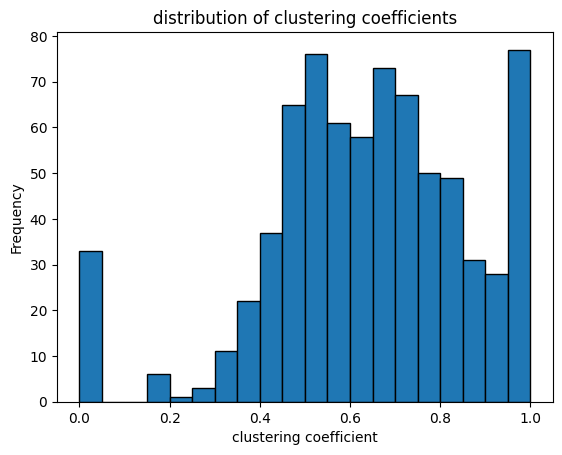

In [11]:
clustering = nx.clustering(LC_G)

plt.hist(list(clustering.values()), bins= 20, edgecolor='black')
plt.title('distribution of clustering coefficients')
plt.xlabel('clustering coefficient')
plt.ylabel('Frequency')
plt.show()

- Plot the dependence of the clustering coefficient on the degree of the vertex

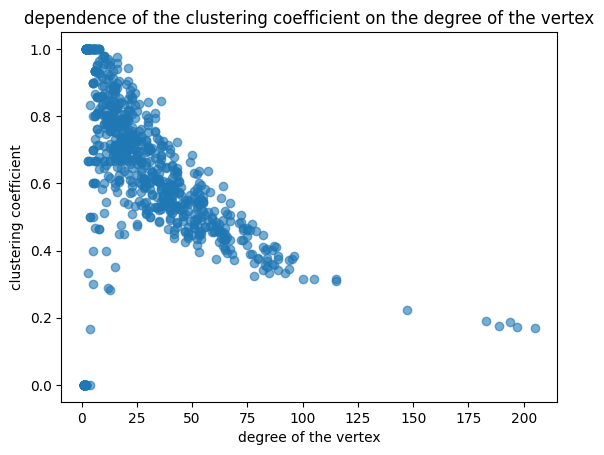

In [38]:
degrees = dict(LC_G.degree())

x = [degrees[node] for node in LC_G.nodes()]
y = [clustering[node] for node in LC_G.nodes()]

plt.scatter(x,y, alpha= 0.6)
plt.title('dependence of the clustering coefficient on the degree of the vertex')
plt.xlabel('degree of the vertex')
plt.ylabel('clustering coefficient')
plt.show()

### 1.2. Path length

- Calculate the average length of the shortest path between two vertices of the graph



In [13]:
paths = dict(nx.all_pairs_shortest_path_length(LC_G))
average_paths = {}

for node in paths.keys():
    average_paths[node] = sum(paths[node].values()) / (len(paths[node].values()) - 1)

print(average_paths)

{'3': 2.962516733601071, '4': 2.8661311914323964, '35': 2.7938420348058903, '37': 2.9062918340026775, '38': 3.0508701472556896, '42': 3.0468540829986615, '43': 2.9223560910307897, '44': 3.5943775100401605, '45': 3.002677376171352, '46': 2.860776439089692, '47': 3.034805890227577, '48': 3.539491298527443, '49': 3.6519410977242304, '50': 2.7322623828647923, '51': 2.7295850066934406, '52': 2.3855421686746987, '53': 2.785809906291834, '54': 2.9116465863453813, '55': 2.352074966532798, '56': 2.352074966532798, '57': 2.7724230254350735, '58': 2.8674698795180724, '59': 3.3373493975903616, '60': 2.9196787148594376, '63': 2.8634538152610443, '64': 2.9544846050870146, '65': 2.7697456492637214, '66': 2.852744310575636, '70': 2.9919678714859437, '71': 3.2342704149933064, '78': 4.688085676037483, '80': 5.686746987951807, '82': 3.6921017402945115, '83': 2.9531459170013385, '85': 3.8406961178045513, '86': 3.8406961178045513, '87': 2.9170013386880855, '88': 3.8299866131191433, '89': 2.959839357429719,

- Plot a histogram of the dependence of the average length of the shortest path on the degree of the vertex

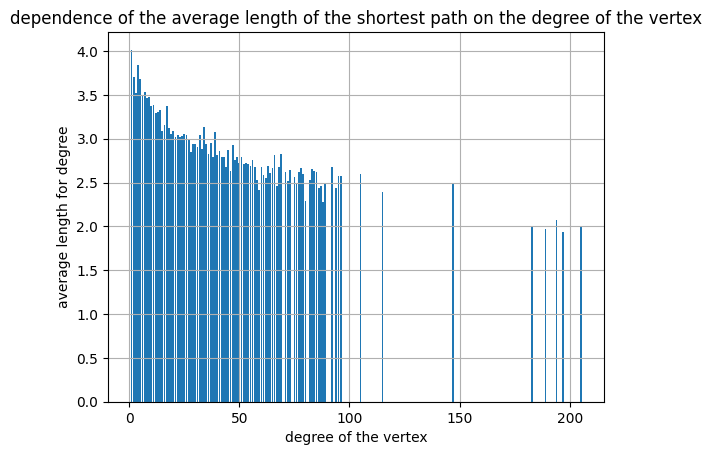

In [14]:
new_dict = defaultdict(list)

for key, value in degrees.items():
    new_dict[value].append(average_paths[key])

x = new_dict.keys()
y = list(map(np.mean,new_dict.values()))
plt.bar(x,y)
plt.title('dependence of the average length of the shortest path on the degree of the vertex')
plt.xlabel('degree of the vertex')
plt.ylabel('average length for degree')
plt.grid()
plt.show()

### 1.3. Distribution of node degrees

- What is the distribution of node degrees? Run goodness-of-fit test and estimate parameters of the distribution.

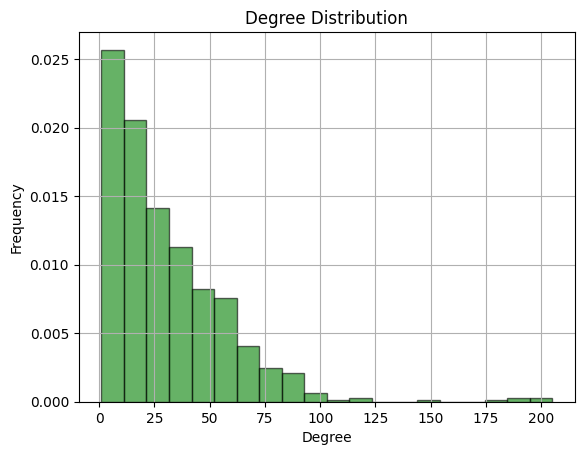

In [15]:
degrees_value = np.array(list(degrees.values()))

plt.hist(degrees_value, bins=20, density=True, alpha=0.6, color='g', edgecolor='black')
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [16]:
num_bins = 20
counts, bin_edges = np.histogram(degrees_value, bins=num_bins, density=True)
bin_centers_exp = 0.5 * (bin_edges[1:] + bin_edges[:-1])

lambda_param = 1 / np.mean(degrees_value)
theoretical_distribution = expon.pdf(bin_centers_exp, scale= 1/lambda_param)
statistic, p_value = ks_2samp(counts, theoretical_distribution)

print(f"KS: {statistic}, p-value: {p_value}")

KS: 0.2, p-value: 0.8319696107963263


In [17]:
best_KS = np.inf
best_xmin = None
diffs = [(0, 0, 0)]
for x_min in range(1,100):
    fit = pw.Fit(degrees_value, xmin= x_min)
    ks = fit.power_law.KS(degrees_value)
    diffs.append((ks, diffs[-1][0] - ks, x_min))
    if ks < best_KS:
        best_KS = ks
        best_xmin = x_min

print(best_xmin, best_KS)
print(sorted(filter(lambda x: x[2] < 25, diffs), key = lambda x: -x[1]))

62 0.06353832388221592
[(np.float64(0.29797508712611287), np.float64(0.019846617656060772), 2), (np.float64(0.19992759890748052), np.float64(0.01736480519227465), 9), (np.float64(0.21729240409975517), np.float64(0.016886642043535904), 8), (np.float64(0.25795123256953884), np.float64(0.016606155431997338), 5), (np.float64(0.2745573880015362), np.float64(0.012908665618146187), 4), (np.float64(0.18742626754058245), np.float64(0.012501331366898072), 10), (np.float64(0.23417904614329108), np.float64(0.01198278958793611), 7), (np.float64(0.24616183573122719), np.float64(0.01178939683831165), 6), (np.float64(0.28746605361968236), np.float64(0.01050903350643051), 3), (np.float64(0.17582407202766243), np.float64(0.006379881031751022), 12), (np.float64(0.18220395305941345), np.float64(0.005222314481168999), 11), (np.float64(0.17032953551137997), np.float64(0.003515353559991885), 17), (np.float64(0.16231623043251608), np.float64(0.0031734175703067025), 23), (np.float64(0.16484487765157396), np.fl

In [18]:
fit = pw.Fit(degrees_value, xmin= 9)
alpha = fit.alpha
xmin = fit.xmin
print(alpha, xmin)

1.8253734222886888 9.0


In [19]:
results = fit.distribution_compare('exponential', 'power_law')
print(f"Log-likelihood ratio: {results[0]}, p-value: {results[1]}")

Log-likelihood ratio: 157.06661497364476, p-value: 1.7075856096261533e-38


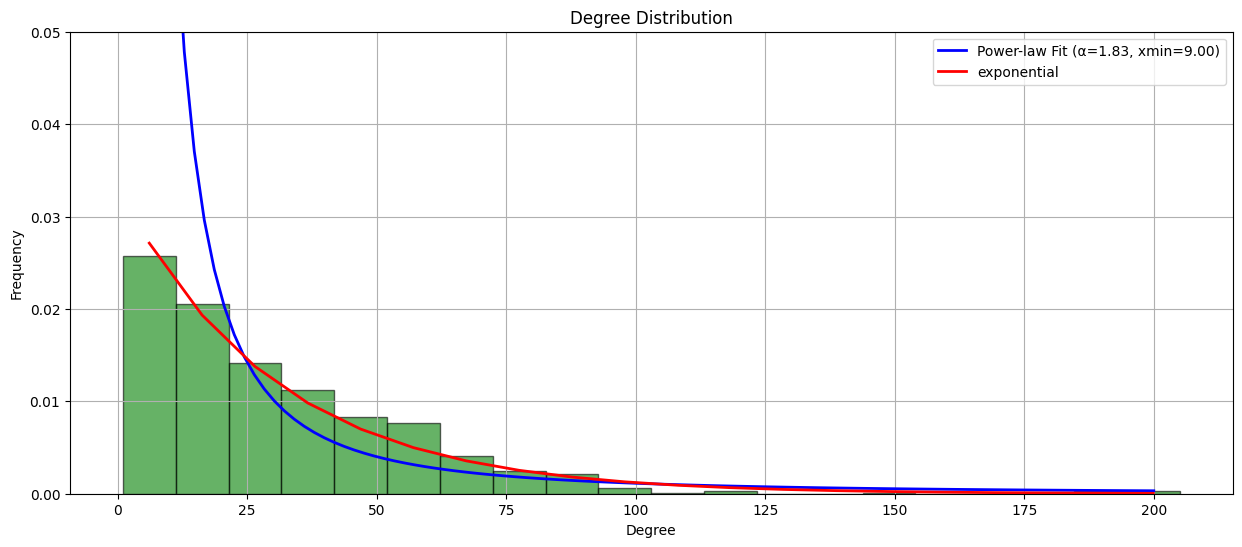

In [20]:
x_powerlaw = np.linspace(xmin, 200, 100)
powerlaw_fit = fit.power_law.pdf(x_powerlaw)
plt.figure(figsize=(15, 6))
plt.plot(x_powerlaw, powerlaw_fit, 'b-', lw=2, label='Power-law Fit (α={:.2f}, xmin={:.2f})'.format(alpha, xmin))
plt.hist(degrees_value, bins=20, density=True, alpha=0.6, color='g', edgecolor='black')
plt.plot(bin_centers_exp, theoretical_distribution, 'r-', lw=2, label='exponential')
plt.ylim(0, 0.05)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

### 1.4. Determine which are the most important and significant neurons in our brain?

In [21]:
sorted_dict_desc = np.array(sorted(nx.betweenness_centrality(LC_G).items(), key=lambda item: item[1], reverse=True))
print(sorted_dict_desc[:5])

[['1008' '0.2421469370007891']
 ['502' '0.18009177720732064']
 ['1009' '0.14644286031118997']
 ['503' '0.14220005565925148']
 ['504' '0.07271998320811557']]


In [22]:
sorted_dict_desc = np.array(sorted(nx.degree_centrality(LC_G).items(), key=lambda item: item[1], reverse=True))
print(sorted_dict_desc[:5])

[['503' '0.27443105756358765']
 ['1008' '0.2637215528781794']
 ['504' '0.2597054886211513']
 ['502' '0.25301204819277107']
 ['1009' '0.24497991967871485']]


In [23]:
sorted_dict_desc = np.array(sorted(nx.closeness_centrality(LC_G).items(), key=lambda item: item[1], reverse=True))
print(sorted_dict_desc[:5])

[['1008' '0.5151724137931034']
 ['502' '0.5064406779661017']
 ['1009' '0.49933155080213903']
 ['503' '0.49899799599198397']
 ['504' '0.4816247582205029']]


In [24]:
sorted_dict_desc = np.array(sorted(nx.eigenvector_centrality(LC_G).items(), key= lambda item: item[1], reverse=True))
print(sorted_dict_desc[:5])

[['502' '0.16786807663662084']
 ['503' '0.16740725044129698']
 ['1008' '0.1665328368755248']
 ['504' '0.15834180189207844']
 ['1009' '0.14440977691784915']]


In [25]:
{int(n) : LC_G.nodes[n].get('dn_name', n) for n in sorted_dict_desc[:,0][:5]}

{502: 'Right-Thalamus-Proper',
 503: 'Right-Caudate',
 1008: 'Left-Thalamus-Proper',
 504: 'Right-Putamen',
 1009: 'Left-Caudate'}

### 1.5. Is the human brain a complex network? Why?

In order for the network to be complex, three conditions must be met
1. High clustering coefficient: we have 0.63
2. Small world: in fact, the fact that the values of the average path are relatively small relative to the number of vertices does not prove anything, since you need to get a logarithmic dependence on N, which means you need to consider several N. I failed to choose subgraphs so that everything was random and at the same time the graph remained connected(((. Therefore, I suggest we just believe that the small average path turned out to be a logarithm
3. Power-law distribution : In principle, the subgraph that we considered can be adjusted to a power-law distribution, this hypothesis cannot be rejected, but the exponential distribution is better suited. Which doesn't mean anything, since we didn't consider the entire graph, which could lead to such results, but the most important thing is that we got tails at the very beginning, which indicates the presence of hubs. Well, the presence of large connected components can also be considered as some kind of proof that our brain is a complex network.

## Problem 2. Labeling of the brain connectome (30 points)

- Create an automatic labeling of the brain's connectome. Labeling refers to the division of connections into a number of groups, and the assignment of each vertex to one of these groups.

- Try several different labeling algorithms and describe how you chose the values for their parameters.

- Compare the results of the different algorithms to each other and to the original labeling.

In [26]:
louvain_partition = community_louvain.best_partition(LC_G)
louvain_labels = [louvain_partition[n] for n in LC_G.nodes()]
louvain_colors = get_node_colors(louvain_labels)

print("Louvain:")
plot_connectome(LC_G, node_colors=louvain_colors)

Louvain:


In [27]:
label_partition = nx.algorithms.community.label_propagation_communities(LC_G)

label_dict = {}
for i, community in enumerate(label_partition):
    for node in community:
        label_dict[node] = i

label_labels = [label_dict[n] for n in LC_G.nodes()]
label_colors = get_node_colors(label_labels)

print("Label Propagation:")
plot_connectome(LC_G, node_colors= label_colors)

Label Propagation:


In [28]:
original_labels = [canonize_key(G.nodes[n].get('dn_name', 'Unknown')) for n in LC_G.nodes()]
original_colors = get_node_colors(original_labels)

print("Original labels")
plot_connectome(LC_G, node_colors= original_colors)

Original labels


In [29]:
le = LabelEncoder()
original_encoded = le.fit_transform(original_labels)

nodes = list(LC_G.nodes())
louvain_encoded = [louvain_partition[n] for n in nodes]
label_encoded = [label_dict[n] for n in nodes]

print(f"Louvain NMI: {normalized_mutual_info_score(original_encoded, louvain_encoded)}")
print(f"Label Propagation NMI: {normalized_mutual_info_score(original_encoded, label_encoded)}")

Louvain NMI: 0.30905282834029085
Label Propagation NMI: 0.21867382813378894


## Problem 3. Assortativity (15 points)

- Рассмотрите:
  - Коннектом целиком
  - Различные области, найденные с помощью автоматической разметки, по отдельности
- Посчитайте для них ассортативность, постройте необходимые графики
- Проанализируйте результаты
- Consider:
  - Connect as a whole
  - Various areas found using automatic labeing individually
- Calculate the assortativity for them, plot the necessary graphs
- Analyze the results

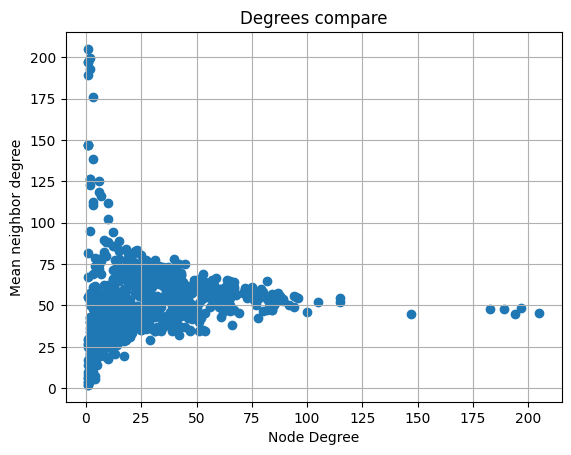


Louvain classters:
claster  0 (Nodes count: 184) - assortativity: -0.06638223627792257
claster  1 (Nodes count: 119) - assortativity: -0.15908498033443003
claster  3 (Nodes count: 73) - assortativity: -0.09249649426699691
claster  4 (Nodes count: 194) - assortativity: -0.009100915100780727
claster  2 (Nodes count: 178) - assortativity: -0.011553073000085417


In [37]:
r = nx.degree_assortativity_coefficient(LC_G)

degrees = dict(LC_G.degree())
neighbor_deg = nx.average_neighbor_degree(LC_G)

x = [degrees[n] for n in LC_G.nodes()]
y = [neighbor_deg[n] for n in LC_G.nodes()]

plt.scatter(x, y, alpha=0.6)
plt.title("Degrees compare")
plt.xlabel("Node Degree")
plt.ylabel("Mean neighbor degree")
plt.grid(True)
plt.show()

clusters = defaultdict(list)
for node, cluster_id in louvain_partition.items():
    clusters[cluster_id].append(node)

print("\nLouvain classters:")
for cluster_id, nodes in clusters.items():
    if len(nodes) < 5:
        continue
    subgraph = LC_G.subgraph(nodes)
    assortatitvity = nx.degree_assortativity_coefficient(subgraph)
    print(f"claster {cluster_id:2d} (Nodes count: {len(nodes)}) - assortativity: {assortatitvity}")

### Conclusion:
The assortativity is low for all clusters, which means that the neurons in this component of the brain have muddied their swinger party.

## Problem 4. Transcranial magnetic stimulation (30 points)

__[Transcranial magnetic stimulation (TMS)](https://en.wikipedia.org/wiki/Transcranial_magnetic_stimulation)__ - a method that allows noninvasively stimulating the cerebral cortex. It is used for the rehabilitation of patients (for example, with motor disorders), and for the treatment of various diseases: Parkinson's disease, epilepsy, depression, schizophrenia, and others.

We would like to suggest that you conduct a TMS on your "patient". For this, you will need:

- "Weigh" the edges of the graph. For example, using some metric that decreases with increasing distance between vertices.

- Apply TMS to different areas of the brain. See how far the signal will spread, which areas it will affect, and what functions these areas are responsible for.

  Various methods can be used to implement signal propagation: `message passing', `random walk', `heat diffusion' and others.

  Try different methods (two or more), compare the results.

---

To determine which areas of the brain should be targeted with TMS, you can refer to scientific articles. For example:

__[Evidence-based guidelines on the therapeutic use of repetitive transcranial magnetic stimulation (rTMS)](https://www.sciencedirect.com/science/article/pii/S1388245719312799?via%3Dihub)__.

This article contains many studies that stimulated various areas of the brain using TMS. It also describes the symptoms of patients and the results of TMS use.

---

For example, in the picture below you can see:

- The patient's symptom is a motor disorder of the hand as a result of stroke.

- The area of application of TMS is the M1 zone. You can use a __[map of brain regions](https://atlas.brain-map.org/atlas?atlas=265297126)__ to orient yourself in the areas of a brain.

- The result of the therapy is an improvement in the patient's motor functions.

![lab_1_example.png](attachment:lab_1_example.png)

---

Good luck!

In [31]:
def euclidean_distance(pos1, pos2):
    return np.linalg.norm(np.array(pos1) - np.array(pos2))

for u, v in LC_G.edges():
    pos_u = np.array([
        float(LC_G.nodes[u]['dn_position_x']),
        float(LC_G.nodes[u]['dn_position_y']),
        float(LC_G.nodes[u]['dn_position_z']),
    ])
    pos_v = np.array([
        float(LC_G.nodes[v]['dn_position_x']),
        float(LC_G.nodes[v]['dn_position_y']),
        float(LC_G.nodes[v]['dn_position_z']),
    ])
    dist = euclidean_distance(pos_u, pos_v)
    weight = 1 / (dist + 1e-3)
    LC_G.edges[u, v]['weight'] = weight

In [32]:
def random_walk(G, start_nodes, alpha=0.85, max_iter=100):
    nodes = list(G.nodes())
    node_idx = {n: i for i, n in enumerate(nodes)}

    p = np.zeros(len(nodes))
    for node in start_nodes:
        p[node_idx[node]] = 1 / len(start_nodes)
    p /= p.sum()

    A = nx.to_numpy_array(G, nodelist=nodes, weight='weight')
    row_sums = A.sum(axis=1, keepdims=True)
    A = A / (row_sums + 1e-9)

    v = p.copy()
    for _ in range(max_iter):
        p = alpha * A @ p + (1 - alpha) * v

    return dict(zip(nodes, p))


def heat_diffusion(G, start_nodes, t=5.0):
    nodes = list(G.nodes())
    node_idx = {n: i for i, n in enumerate(nodes)}

    A = nx.to_numpy_array(G, nodelist=nodes, weight='weight')
    D = np.diag(A.sum(axis=1))
    L = D - A
    f0 = np.zeros(len(nodes))

    for node in start_nodes:
        f0[node_idx[node]] = 1.0

    f0 /= f0.sum()

    ft = expm(-L * t) @ f0
    return dict(zip(nodes, ft))

In [33]:
def top_activity(score_dict, top= 10):
    sorted_nodes = sorted(score_dict.items(), key= lambda x: -x[1])
    top = sorted_nodes[:top]

    data = pd.DataFrame([
        {
            'Brain_area': LC_G.nodes[n].get('dn_name', n),
            'region': LC_G.nodes[n].get('dn_region', ''),
            'hemisphere': LC_G.nodes[n].get('dn_hemisphere', ''),
            'function': brain_area_function(canonize_key(LC_G.nodes[n].get('dn_name', n))),
            'signal_intensity': f"{score}",
        }
        for n, score in top
    ])
    return data

In [34]:
target_areas = ['Precentral', 'Rostralmiddlefrontal']

stim_nodes = [node for node, data in LC_G.nodes(data=True)
    if canonize_key(data.get('dn_name', '')) in target_areas]

rw_scores = random_walk(LC_G, stim_nodes)
heat_scores = heat_diffusion(LC_G, stim_nodes)

RandomWalk = top_activity(rw_scores)
HeatDiffusion = top_activity(heat_scores)

In [35]:
RandomWalk.head(10)

Brain_area    region hemisphere  \
0  lh.rostralmiddlefrontal_16  cortical       left   
1  lh.rostralmiddlefrontal_24  cortical       left   
2            rh.precentral_30  cortical      right   
3            rh.precentral_18  cortical      right   
4            lh.precentral_14  cortical       left   
5  rh.rostralmiddlefrontal_15  cortical      right   
6            lh.precentral_13  cortical       left   
7            rh.precentral_14  cortical      right   
8            rh.precentral_10  cortical      right   
9             rh.precentral_2  cortical      right   

                          function       signal_intensity  
0        Planning, decision-making   0.005959013987319807  
1        Planning, decision-making  0.0052458988275008766  
2  Movement control (motor cortex)   0.005068509356328499  
3  Movement control (motor cortex)   0.005062020824044948  
4  Movement control (motor cortex)   0.004927795801877683  
5        Planning, decision-making   0.004854392242097608  
6  Movement control (motor cortex)  0.0048224880088496005  
7  Movement control (motor cortex)   0.004812421905819434  
8  Movement control (motor cortex)   0.004751560450696824  
9  Movement control (motor cortex)  0.0047497970997224135

In [36]:
HeatDiffusion.head(10)

Brain_area    region hemisphere  \
0  lh.rostralmiddlefrontal_16  cortical       left   
1            lh.precentral_14  cortical       left   
2   lh.rostralmiddlefrontal_7  cortical       left   
3   rh.rostralmiddlefrontal_6  cortical      right   
4  lh.rostralmiddlefrontal_24  cortical       left   
5            lh.precentral_10  cortical       left   
6            lh.precentral_13  cortical       left   
7  rh.rostralmiddlefrontal_15  cortical      right   
8             lh.precentral_2  cortical       left   
9  lh.rostralmiddlefrontal_26  cortical       left   

                          function       signal_intensity  
0        Planning, decision-making   0.007255848000505744  
1  Movement control (motor cortex)   0.005540521185076221  
2        Planning, decision-making   0.005533343951793708  
3        Planning, decision-making   0.005087032063524183  
4        Planning, decision-making   0.004859393583300382  
5  Movement control (motor cortex)   0.004336087580735095  
6  Movement control (motor cortex)  0.0038441799262350735  
7        Planning, decision-making   0.003831792043833145  
8  Movement control (motor cortex)  0.0034372956167823578  
9        Planning, decision-making  0.0030991597910043083